In [20]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

import matplotlib.font_manager as fm
font_path = "/usr/share/fonts/google-noto-cjk/NotoSerifCJK-Bold.ttc"
plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['axes.unicode_minus'] = False


class EntityRelationAnalyzer:
    def __init__(self, json_file_path):
        """初始化分析器"""
        with open(json_file_path, 'r', encoding='utf-8') as f:
            self.data = json.load(f)
        
        self.entities = self.data['entities']
        self.relations = self.data['relations']
        self.G = self._build_graph()
    
    def _build_graph(self):
        """构建NetworkX图"""
        G = nx.DiGraph()
        
        # 添加节点
        for entity in self.entities:
            G.add_node(entity['name'], type=entity['type'])
        
        # 添加边
        for relation in self.relations:
            G.add_edge(relation['head'], relation['tail'], 
                      relation_type=relation['type'])
        
        return G
    
    def entity_statistics(self):
        """实体统计分析"""
        print("=== 实体统计分析 ===")
        
        # 实体类型分布
        entity_types = [entity['type'] for entity in self.entities]
        type_counts = Counter(entity_types)
        
        print(f"总实体数: {len(self.entities)}")
        print("\n实体类型分布:")
        for entity_type, count in type_counts.most_common():
            print(f"  {entity_type}: {count}")
    

        # 使用 seaborn 配色方案
        sns.set_palette('muted')

        plt.figure(figsize=(10, 6))
        types, counts = zip(*type_counts.most_common())
        plt.bar(types, counts)
        plt.title('实体类型分布')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('entity_type_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return type_counts
    
    def relation_statistics(self):
        """关系统计分析"""
        print("\n=== 关系统计分析 ===")
        
        relation_types = [relation['type'] for relation in self.relations]
        relation_counts = Counter(relation_types)
        
        print(f"总关系数: {len(self.relations)}")
        print("\n关系类型分布:")
        for rel_type, count in relation_counts.most_common():
            print(f"  {rel_type}: {count}")
        
        return relation_counts
    
    def network_analysis(self):
        """网络拓扑分析"""
        print("\n=== 网络拓扑分析 ===")
        
        # 基本网络统计
        print(f"节点数: {self.G.number_of_nodes()}")
        print(f"边数: {self.G.number_of_edges()}")
        print(f"平均度: {sum(dict(self.G.degree()).values()) / self.G.number_of_nodes():.2f}")
        
        # 度中心性分析
        degree_centrality = nx.degree_centrality(self.G)
        top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
        
        print("\n度中心性TOP10:")
        for node, centrality in top_degree:
            print(f"  {node}: {centrality:.3f}")
        
        # 介数中心性分析
        betweenness_centrality = nx.betweenness_centrality(self.G)
        top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
        
        print("\n介数中心性TOP10:")
        for node, centrality in top_betweenness:
            print(f"  {node}: {centrality:.3f}")
        
        return {
            'degree_centrality': degree_centrality,
            'betweenness_centrality': betweenness_centrality
        }
    
    def community_detection(self):
        """社区检测/聚类分析"""
        print("\n=== 社区检测分析 ===")
        
        # 转换为无向图进行社区检测
        G_undirected = self.G.to_undirected()
        
        # 使用Louvain算法进行社区检测
        try:
            import community as community_louvain
            communities = community_louvain.best_partition(G_undirected)
        except ImportError:
            # 使用NetworkX内置的贪心模块化算法
            communities_iter = nx.community.greedy_modularity_communities(G_undirected)
            communities = {}
            for i, community in enumerate(communities_iter):
                for node in community:
                    communities[node] = i
        
        # 统计社区
        community_counts = Counter(communities.values())
        print(f"检测到 {len(community_counts)} 个社区")
        
        # 打印各社区的节点
        community_nodes = defaultdict(list)
        for node, community_id in communities.items():
            community_nodes[community_id].append(node)
        
        for community_id, nodes in community_nodes.items():
            print(f"\n社区 {community_id} ({len(nodes)} 个节点):")
            print(f"  {', '.join(nodes[:5])}{'...' if len(nodes) > 5 else ''}")
        
        return communities
    
    def pathway_analysis(self):
        """路径分析"""
        print("\n=== 路径分析 ===")
        
        # 寻找重要节点间的最短路径
        important_nodes = ['ARG', 'ARB', '抗生素耐药性', '宏基因组学']
        
        for i, source in enumerate(important_nodes):
            for target in important_nodes[i+1:]:
                try:
                    if nx.has_path(self.G, source, target):
                        path = nx.shortest_path(self.G, source, target)
                        print(f"{source} -> {target}: {' -> '.join(path)}")
                except nx.NetworkXNoPath:
                    print(f"{source} -> {target}: 无路径")
    
    def trajectory_analysis(self):
        """轨迹分析 - 基于实体类型的演化模式"""
        print("\n=== 轨迹分析 ===")
        
        # 按实体类型分组
        type_groups = defaultdict(list)
        for entity in self.entities:
            type_groups[entity['type']].append(entity['name'])
        
        # 分析类型间的关系模式
        type_relations = defaultdict(int)
        for relation in self.relations:
            head_type = next(e['type'] for e in self.entities if e['name'] == relation['head'])
            tail_type = next(e['type'] for e in self.entities if e['name'] == relation['tail'])
            type_relations[f"{head_type} -> {tail_type}"] += 1
        
        print("实体类型间关系频次:")
        for relation, count in sorted(type_relations.items(), key=lambda x: x[1], reverse=True):
            print(f"  {relation}: {count}")
    
    def generate_summary_report(self):
        """生成综合分析报告"""
        print("\n" + "="*50)
        print("综合分析报告")
        print("="*50)
        
        # 执行所有分析
        entity_stats = self.entity_statistics()
        relation_stats = self.relation_statistics()
        network_stats = self.network_analysis()
        communities = self.community_detection()
        # self.pathway_analysis()
        # self.trajectory_analysis()
        
        # 生成洞察
        print("\n=== 关键洞察 ===")
        
        # 最重要的实体类型
        top_entity_type = max(entity_stats, key=entity_stats.get)
        print(f"1. 最主要的实体类型: {top_entity_type} ({entity_stats[top_entity_type]} 个)")
        
        # 最重要的关系类型
        top_relation_type = max(relation_stats, key=relation_stats.get)
        print(f"2. 最主要的关系类型: {top_relation_type} ({relation_stats[top_relation_type]} 个)")
        
        # 网络中心节点
        top_central_node = max(network_stats['degree_centrality'], 
                             key=network_stats['degree_centrality'].get)
        print(f"3. 网络中心节点: {top_central_node}")
        
        # 社区数量
        print(f"4. 检测到 {len(set(communities.values()))} 个知识社区")


# 运行2024年知识库

In [22]:
entity_relations_file = "/mnt/data/liuchangle/biopython/My_scientific_trajectory/chatECNU/results/chunk_of_2024/integrated_entities_relations.json"
analyzer = EntityRelationAnalyzer(entity_relations_file)

=== 实体统计分析 ===
总实体数: 1112

实体类型分布:
  生物信息工具: 382
  深度学习概念: 364
  生物分子: 116
  其他: 103
  项目活动: 79
  生物技术: 34
  生物医学概念: 30
  命令: 2
  数据库: 1
  生物信息项目: 1


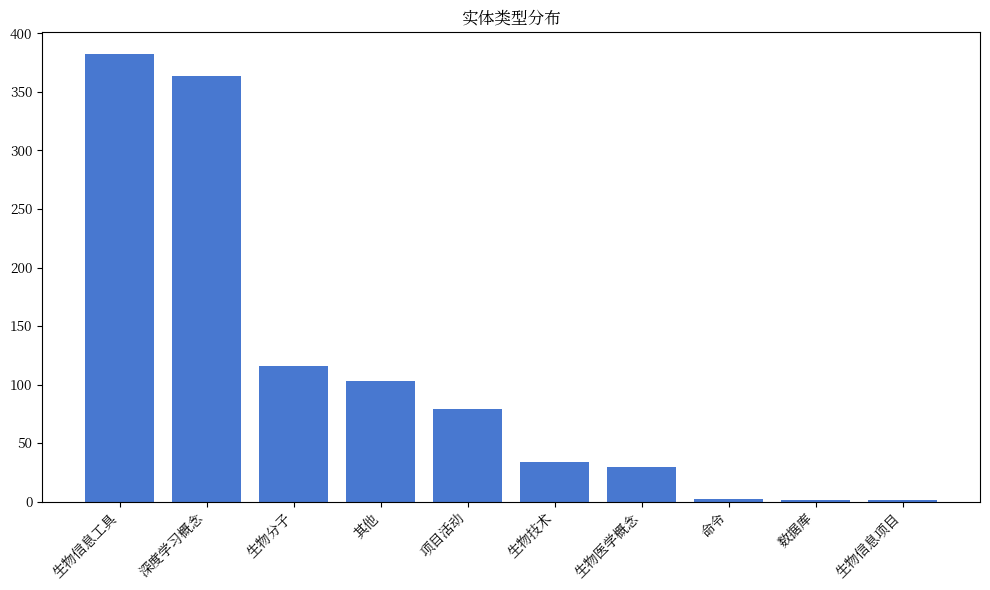

In [23]:
entity_stats = analyzer.entity_statistics()


In [24]:
relation_stats = analyzer.relation_statistics()
network_stats = analyzer.network_analysis()
communities = analyzer.community_detection()


=== 关系统计分析 ===
总关系数: 1916

关系类型分布:
  使用: 719
  属于: 553
  包含: 333
  调控: 63
  用于: 51
  因果: 35
  生成: 9
  优于: 9
  与: 6
  安装: 6
  解决: 6
  导致: 5
  表示: 5
  提供: 5
  输出: 4
  结合: 4
  整合: 4
  研究: 3
  训练: 3
  预测: 3
  实现: 3
  形成: 3
  可以通过: 3
  作用: 3
  基于: 3
  交叉应用: 3
  目的: 3
  初始化: 2
  容易误判: 2
  具有: 2
  处理: 2
  解决方案: 2
  转换: 2
  与...一起使用: 2
  协同工作: 2
  比较: 2
  收录: 2
  构建: 2
  改进: 2
  激活: 1
  冲突: 1
  替代: 1
  缺少: 1
  目标: 1
  教程: 1
  捕获: 1
  学习: 1
  应对: 1
  核心: 1
  尝试: 1
  修改: 1
  相似: 1
  不兼容: 1
  错误: 1
  输入: 1
  决定: 1
  比: 1
  存在: 1
  产出: 1
  编写: 1
  缺乏: 1
  接触: 1
  可视化: 1
  需要: 1
  报错: 1
  映射到: 1
  关注: 1
  输入输出: 1
  跨越: 1
  衡量: 1
  关联: 1
  与...相关: 1
  涉及: 1
  定义: 1
  优化目标: 1
  建议使用: 1
  消除方法: 1
  视为: 1
  缓解: 1
  区别于: 1
  本质: 1
  方法: 1
  不考虑: 1
  依赖: 1

=== 网络拓扑分析 ===
节点数: 1502
边数: 1893
平均度: 2.52

度中心性TOP10:
  深度学习概念: 0.062
  ProteinBERT: 0.045
  生物信息工具: 0.040
  Transformer: 0.039
  Linux: 0.035
  深度学习: 0.029
  蛋白质: 0.026
  项目活动: 0.025
  PyTorch: 0.020
  深度学习模型: 0.018

介数中心性TOP10:
  深度学习: 0.029
  Tr